#### Gruop: Jingmin Chen, Yusen Wu

## Credit Card Fraud Detection Project

In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score,confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler

data = pd.read_csv("creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
import keras.backend as K
from keras.preprocessing.image import save_img
from sklearn.metrics import confusion_matrix,classification_report

Using TensorFlow backend.


In [3]:
Fraud = data[data['Class']==1]
Normal = data[data['Class']==0]
print("Fraud: ",len(Fraud))
print("total: ",len(data))
print("Fraud rate: ",round((len(Fraud)/len(data)),5))
Y = data['Class']
X = data.drop(['Class'],axis=1)

Fraud:  492
total:  284807
Fraud rate:  0.00173


In [4]:
undersample = RandomUnderSampler(sampling_strategy=0.0035)

###  Feature selection

In [5]:
dfcorr = data.corr()
features = dfcorr.Class[dfcorr.Class.abs()>0.04].index
features = list(features)
features.remove('Class')
print("Number of selected features: ",len(features))
features

Number of selected features:  16


['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V9',
 'V10',
 'V11',
 'V12',
 'V14',
 'V16',
 'V17',
 'V18',
 'V21']

In [401]:
# drop extra features
Y = data['Class']
X = data.drop(['Class','Time','Amount','V8','V13','V15','V19','V20','V22','V23','V24','V25','V26','V27','V28'],axis=1)

In [402]:
# Use random undersample technique to reduce the size of normal data to about half of the original data
X_half, y_half = undersample.fit_resample(X, Y)
print("Number of Normal data: ",y_half[y_half == 0].shape)
print("Number of Fraud data: ", y_half[y_half == 1].shape)

Number of Normal data:  (140571,)
Number of Fraud data:  (492,)


In [403]:
# Split data to 0.9 training set and 0.1 test set
# split 0.2 validate set from 0.9 training set
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_half, y_half, test_size=0.1, random_state=7)

X_train2, X_validate, y_train2, y_validate = train_test_split(X_train, Y_train, 
                                                            test_size=0.2, random_state=42)
# Apply Standard Scaler for data transformation
scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_validate = scalar.transform(X_validate)
X_test = scalar.transform(X_test)


In [404]:
# Reshape 16 features to 4*4 for CNN model
X_test = X_test.reshape(X_test.shape[0],4,4,1)
X_validate = X_validate.reshape(X_validate.shape[0],4,4,1)
X_train1 = X_train.reshape(X_train.shape[0],4,4,1)

In [386]:
# Create CNN model
model = Sequential()
model.add(Conv2D(32,(2,2),activation='relu', input_shape=X_train1[0].shape))
# Allows higher learning rates and increasing the training speed
model.add(BatchNormalization())
# Reduces the computational cost by reducing the number of parameters
model.add(MaxPooling2D(2,2))


model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))


model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 4, 5, 32)          160       
_________________________________________________________________
batch_normalization_30 (Batc (None, 4, 5, 32)          128       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_31 (Flatten)         (None, 128)               0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 257       
Total para

#### CNN model with selected features

In [388]:
# Fit model
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
History = model.fit(X_train1, Y_train,  
              epochs=20,
            validation_data=(X_validate, y_validate)
             )

Train on 126956 samples, validate on 25392 samples
Epoch 1/20
126956/126956 [==============================] - 23s 181us/step - loss: 0.0366 - acc: 0.9968 - val_loss: 0.0075 - val_acc: 0.9990
Epoch 2/20
126956/126956 [==============================] - 21s 163us/step - loss: 0.0112 - acc: 0.9983 - val_loss: 0.0108 - val_acc: 0.9969
Epoch 3/20
126956/126956 [==============================] - 21s 164us/step - loss: 0.0086 - acc: 0.9985 - val_loss: 0.0054 - val_acc: 0.9992
Epoch 4/20
126956/126956 [==============================] - 21s 165us/step - loss: 0.0083 - acc: 0.9986 - val_loss: 0.0054 - val_acc: 0.9991
Epoch 5/20
126956/126956 [==============================] - 21s 164us/step - loss: 0.0091 - acc: 0.9985 - val_loss: 0.0047 - val_acc: 0.9992
Epoch 6/20
126956/126956 [==============================] - 21s 169us/step - loss: 0.0072 - acc: 0.9987 - val_loss: 0.0050 - val_acc: 0.9991
Epoch 7/20
126956/126956 [==============================] - 21s 164us/step - loss: 0.0070 - acc: 0.9987

Accuracy Score:  0.9990075848869355
Precision Score:  0.9375
Recall Score:  0.8035714285714286
F1 score:  0.8653846153846154
False negative rate:  0.19642857142857142


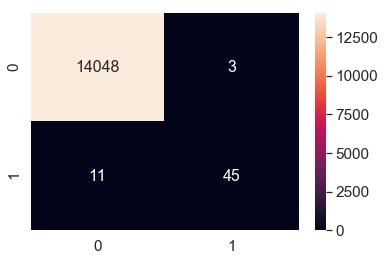

In [115]:
y_test_pred = model.predict(X_test)
df_cm = pd.DataFrame(confusion_matrix(Y_test, y_test_pred.round()), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
print("Accuracy Score: ",accuracy_score(Y_test, y_test_pred.round()))
print("Precision Score: ",precision_score(Y_test, y_test_pred.round()))
print("Recall Score: ",recall_score(Y_test, y_test_pred.round()))
print("F1 score: ",f1_score(Y_test, y_test_pred.round()))
print("False negative rate: ",df_cm[0][1]/(df_cm[0][1]+df_cm[1][1]))

In [227]:
# Use all features
Y = data['Class']
X = data.drop(['Class'],axis=1)
X_half, y_half = undersample.fit_resample(X, Y)

In [372]:
# Split data to Training set and test set
X_train, X_test, Y_train, Y_test = train_test_split(X_half, y_half, test_size=0.1, random_state=7)

X_train2, X_validate, y_train2, y_validate = train_test_split(X_train, Y_train, 
                                                            test_size=0.2, random_state=42)
scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_validate = scalar.transform(X_validate)
X_test = scalar.transform(X_test)


In [374]:
# Use Smote technique
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
Xsm_train, ysm_train = sm.fit_sample(X_train, Y_train)

In [375]:
# Reshape 30 features to 5*6 from CNN model
Xsm_train1 = Xsm_train.reshape(Xsm_train.shape[0],5,6,1)
X_test = X_test.reshape(X_test.shape[0],5,6,1)
X_validate = X_validate.reshape(X_validate.shape[0],5,6,1)
X_train1 = X_train.reshape(X_train.shape[0],5,6,1)

In [390]:
# Create model
model = Sequential()
model.add(Conv2D(32,(2,2),activation='relu', input_shape=X_train1[0].shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))


model.add(Flatten())
model.add(Dropout(0.4))#0.2 - 0.5
model.add(Dense(256, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 4, 5, 32)          160       
_________________________________________________________________
batch_normalization_31 (Batc (None, 4, 5, 32)          128       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_32 (Flatten)         (None, 128)               0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_64 (Dense)             (None, 1)                 257       
Total para

#### CNN model with SMOTE

In [382]:
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
History = model.fit(Xsm_train1, ysm_train,  
              epochs=20,
            validation_data=(X_validate, y_validate)
             )

Train on 253040 samples, validate on 25392 samples
Epoch 1/20
253040/253040 [==============================] - 36s 142us/step - loss: 0.1101 - acc: 0.9581 - val_loss: 0.0568 - val_acc: 0.9828
Epoch 2/20
253040/253040 [==============================] - 32s 126us/step - loss: 0.0598 - acc: 0.9783 - val_loss: 0.0403 - val_acc: 0.9875
Epoch 3/20
253040/253040 [==============================] - 32s 127us/step - loss: 0.0479 - acc: 0.9834 - val_loss: 0.0312 - val_acc: 0.9904
Epoch 4/20
253040/253040 [==============================] - 32s 128us/step - loss: 0.0409 - acc: 0.9862 - val_loss: 0.0242 - val_acc: 0.9927
Epoch 5/20
253040/253040 [==============================] - 33s 129us/step - loss: 0.0369 - acc: 0.9877 - val_loss: 0.0211 - val_acc: 0.9937
Epoch 6/20
253040/253040 [==============================] - 34s 135us/step - loss: 0.0341 - acc: 0.9887 - val_loss: 0.0234 - val_acc: 0.9923
Epoch 7/20
253040/253040 [==============================] - 34s 135us/step - loss: 0.0319 - acc: 0.9897

Accuracy Score:  0.9927695470333877
Precision Score:  0.35064935064935066
Recall Score:  0.9642857142857143
F1 score:  0.5142857142857143
False negative rate:  0.03571428571428571


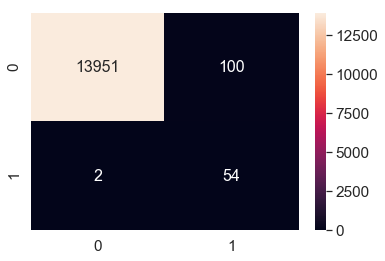

In [383]:
y_test_pred = model.predict(X_test)
df_cm = pd.DataFrame(confusion_matrix(Y_test, y_test_pred.round()), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
print("Accuracy Score: ",accuracy_score(Y_test, y_test_pred.round()))
print("Precision Score: ",precision_score(Y_test, y_test_pred.round()))
print("Recall Score: ",recall_score(Y_test, y_test_pred.round()))
print("F1 score: ",f1_score(Y_test, y_test_pred.round()))
print("False negative rate: ",df_cm[0][1]/(df_cm[0][1]+df_cm[1][1]))

In [380]:
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
History = model.fit(X_train1, Y_train,  
              epochs=25,
              validation_data=(X_validate, y_validate)
             )

Train on 126956 samples, validate on 25392 samples
Epoch 1/25
126956/126956 [==============================] - 21s 165us/step - loss: 0.0265 - acc: 0.9976 - val_loss: 0.0062 - val_acc: 0.9991
Epoch 2/25
126956/126956 [==============================] - 16s 129us/step - loss: 0.0097 - acc: 0.9984 - val_loss: 0.0059 - val_acc: 0.9989
Epoch 3/25
126956/126956 [==============================] - 17s 131us/step - loss: 0.0089 - acc: 0.9985 - val_loss: 0.0055 - val_acc: 0.9989
Epoch 4/25
126956/126956 [==============================] - 17s 131us/step - loss: 0.0085 - acc: 0.9987 - val_loss: 0.0064 - val_acc: 0.9987
Epoch 5/25
126956/126956 [==============================] - 17s 133us/step - loss: 0.0080 - acc: 0.9987 - val_loss: 0.0054 - val_acc: 0.9991
Epoch 6/25
126956/126956 [==============================] - 17s 134us/step - loss: 0.0068 - acc: 0.9987 - val_loss: 0.0046 - val_acc: 0.9991
Epoch 7/25
126956/126956 [==============================] - 17s 134us/step - loss: 0.0071 - acc: 0.9987

Accuracy Score:  0.9995746792372581
Precision Score:  0.9807692307692307
Recall Score:  0.9107142857142857
F1 score:  0.9444444444444444
False negative rate:  0.08928571428571429


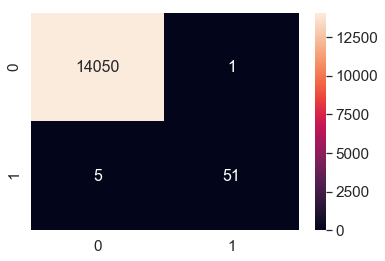

In [26]:
y_test_pred = model.predict(X_test)
df_cm = pd.DataFrame(confusion_matrix(Y_test, y_test_pred.round()), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
print("Accuracy Score: ",accuracy_score(Y_test, y_test_pred.round()))
print("Precision Score: ",precision_score(Y_test, y_test_pred.round()))
print("Recall Score: ",recall_score(Y_test, y_test_pred.round()))
print("F1 score: ",f1_score(Y_test, y_test_pred.round()))
print("False negative rate: ",df_cm[0][1]/(df_cm[0][1]+df_cm[1][1]))

### Result

Models| TP| FP | TN | FN | Recall | Precision | F1 Score | Accuracy
 :- | :- |  :- | :- |:- |:- |:- |:- |:-
CNN with all features| 51|1|14049|5|0.911|0.981|0.944|0.9996
CNN with selected features| 45|3|14048|11|0.804|0.938|0.865|0.999
CNN with SMOTE| 54|100| 13951| 2| 0.964|0.35|0.524|0.993|

CNN with Smote has highest Recall, but since Smote technique generate too much noise, so it decrease the precision, overall, we think CNN with all features would be the best model, it reached highest, precision, F1 score, accuracy and 0.911 recall.